# Reference
https://github.com/wjbmattingly/ocr_python_textbook/blob/main/02_02_working%20with%20opencv.ipynb

In [2]:
!pip install opencv-python pytesseract

In [3]:
import pytesseract
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

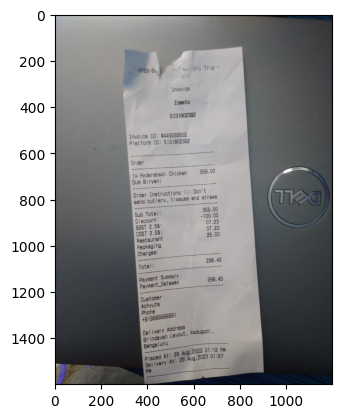

In [19]:
image = cv2.imread("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")
base_image = image.copy()
plt.imshow(image);

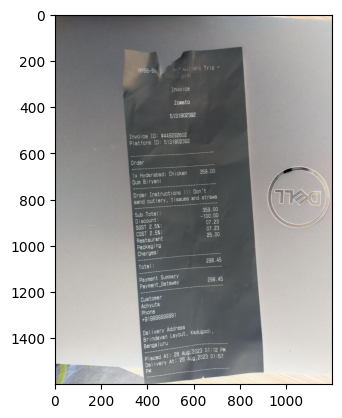

In [20]:
inverted_image = cv2.bitwise_not(image)
#cv2.imwrite("temp/inverted.jpg", inverted_image)
plt.imshow(inverted_image);

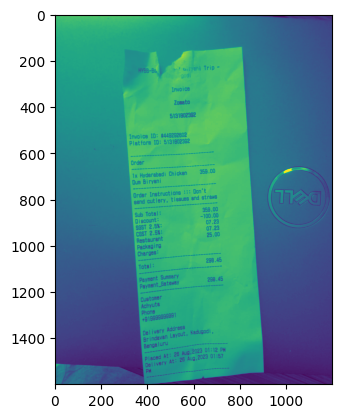

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray);

In [ ]:
cv2.imwrite("temp/index_gray.png", gray)

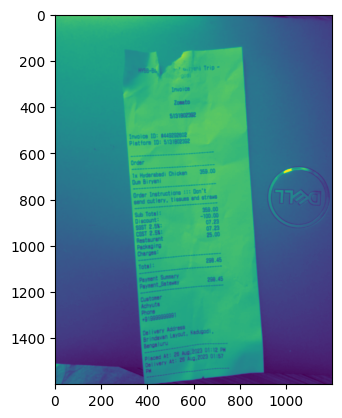

In [6]:
blur = cv2.GaussianBlur(gray, (7,7), 0)
plt.imshow(blur);

In [ ]:
cv2.imwrite("temp/index_blur.png", blur)

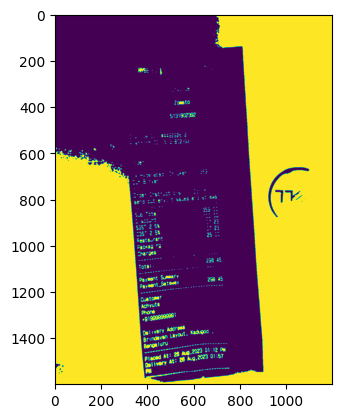

In [7]:
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh);

In [ ]:
cv2.imwrite("temp/index_thresh.png", thresh)

In [21]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

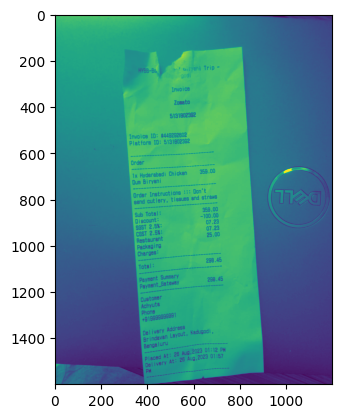

In [22]:
gray_image = grayscale(image)
#cv2.imwrite("temp/gray.jpg", gray_image)
plt.imshow(gray_image);

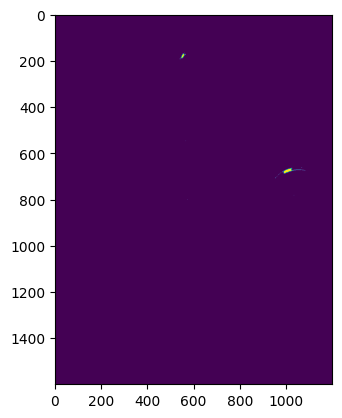

In [23]:
thresh, im_bw = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)
#cv2.imwrite("temp/bw_image.jpg", im_bw)
plt.imshow(im_bw);

In [ ]:
#display("temp/bw_image.jpg")

In [24]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

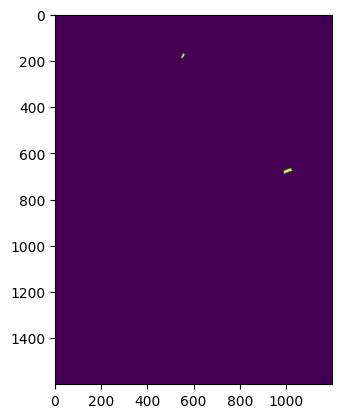

In [25]:
no_noise = noise_removal(im_bw)
#cv2.imwrite("temp/no_noise.jpg", no_noise)
plt.imshow(no_noise);

In [26]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

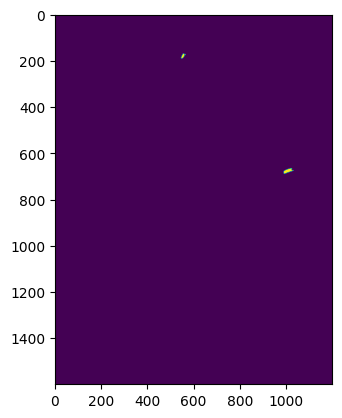

In [29]:
eroded_image = thin_font(no_noise)
#cv2.imwrite("temp/eroded_image.jpg", eroded_image)
plt.imshow(eroded_image);

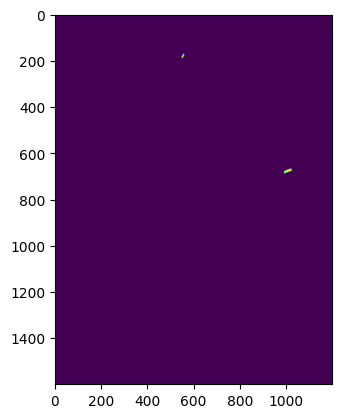

In [30]:
dilated_image = thick_font(no_noise)
#cv2.imwrite("temp/dilated_image.jpg", dilated_image)
plt.imshow(dilated_image);

In [31]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [32]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

44


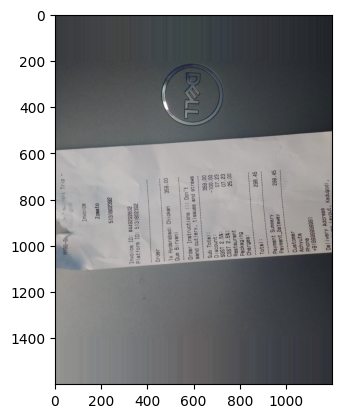

In [33]:
# if image is rotarted
fixed = deskew(image)
#cv2.imwrite("temp/rotated_fixed.jpg", fixed)
plt.imshow(fixed);

In [34]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

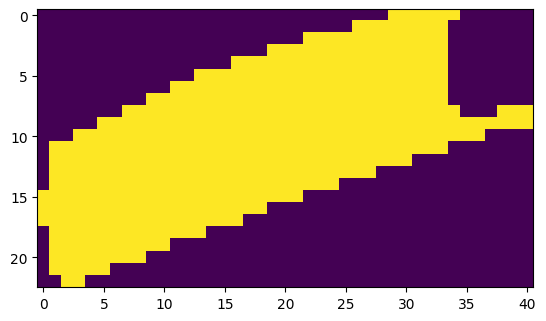

In [35]:
no_borders = remove_borders(no_noise)
#cv2.imwrite("temp/no_borders.jpg", no_borders)
#display('temp/no_borders.jpg')
plt.imshow(no_borders);

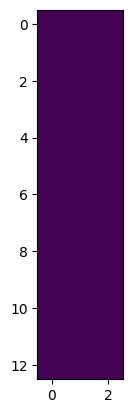

In [8]:
kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
plt.imshow(kernal);

In [ ]:
cv2.imwrite("temp/index_kernal.png", kernal)

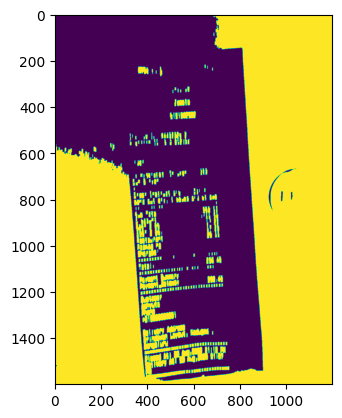

In [9]:
dilate = cv2.dilate(thresh, kernal, iterations=1)
plt.imshow(dilate);

In [ ]:
cv2.imwrite("temp/index_dilate.png", dilate)

In [10]:
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [11]:
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

In [12]:
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

In [14]:
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 200 and w > 20:
        roi = image[y:y+h, x:x+h]
        cv2.imwrite("index_roi.png", roi)
        cv2.rectangle(image, (x, y), (x+w, y+h), (36, 255, 12), 2)
#cv2.imwrite("temp/index_bbox_new.png", image)

In [16]:
results  = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 200 and w > 20:
        roi = image[y:y+h, x:x+h]
        cv2.rectangle(image, (x, y), (x+w, y+h), (36, 255, 12), 2)
        #ocr_result = pytesseract.image_to_string(roi)
        #ocr_result = ocr_result.split("\n")
        #for item in ocr_result:
        #    results.append(item)
cv2.imwrite("index_bbox_new.png", image)

True

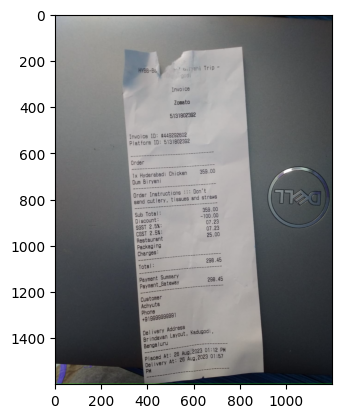

In [17]:
plt.imshow(image);